# Barcode Match

Intuitively, we would expect the PU track distributions *not* to be affected by the jet flavor.

However, when I was looking at the track distributions broken down by the track origin, I saw may PU distributions that weren't making sense to me, such as the $s_{d0}$ distribution below.

<img src="../../figures/PU_studies/sd0_PU.pdf" width="400">

In this notebook, I expore the impact that the ordering for the assignment `jet_trk_orig` variable has for the distributions.

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr
import uproot
from tqdm import tqdm
import glob 

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *
from root_to_np import get_sort_index, passJet, saveData, loadData, getdR, scale
from matplotlib.colors import LogNorm
from termcolor import colored

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


The track origin variable is defined according to the flow chart below:
 
<img src="../../figures/trk_orig.png" width="400">
 
In summer 2017 I ran into this issue as well that sometimes truth particles that were matched to a B would be labelled as PU by the trk_orig variables.

Since it only happened 2% of the time, at that point, we weren't that concerned with this effect, but Michael suggested that we 
- redo the labelling scheme for defining the track origin by *first* checking for b or c-hadron parentage
- see how this impacts our track distributions!
 
I'm doing this study first because I can do this w/o adding new info to the retagging framework, so it seems like a simpler problem to tackle!

Ok, so I think there are two variables I could use to solve this problem now:
- Use a barcode match
- Use a match to the truth pdg id

In [2]:
fname = "../../../public/user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMTo/user.bdong.16276417.Akt4EMTo._000002.root"

In [3]:
# Access the ttree
myTree = uproot.open(fname)["bTag_AntiKt4EMTopoJets"]   

In [4]:
myTree.array(b'avgmu')

array([34.49, 51.5 , 47.49, ..., 59.5 , 59.5 , 37.5 ], dtype=float32)

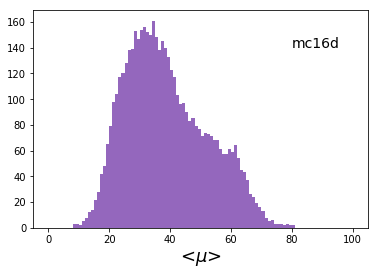

In [5]:
plt.hist(myTree.array(b'avgmu'),color='C4',bins=100,range=(0,100))
plt.xlabel('<$\mu$>',fontsize=18)
plt.text(80,140,'mc16d',fontsize=14)
plt.show()

In [6]:
for key in myTree.keys():
    print(key)

b'runnb'
b'eventnb'
b'mcchan'
b'mcwg'
b'avgmu'
b'actmu'
b'PVx'
b'PVy'
b'PVz'
b'truth_PVx'
b'truth_PVy'
b'truth_PVz'
b'njets'
b'jet_pt'
b'jet_eta'
b'jet_phi'
b'jet_E'
b'jet_pt_orig'
b'jet_eta_orig'
b'jet_phi_orig'
b'jet_E_orig'
b'jet_LabDr_HadF'
b'jet_DoubleHadLabel'
b'jet_JVT'
b'jet_m'
b'jet_nConst'
b'jet_dRiso'
b'jet_truthMatch'
b'jet_isPU'
b'jet_aliveAfterOR'
b'jet_aliveAfterORmu'
b'jet_isBadMedium'
b'jet_truthPt'
b'jet_dRminToB'
b'jet_dRminToC'
b'jet_dRminToT'
b'jet_dl1_pb'
b'jet_dl1_pc'
b'jet_dl1_pu'
b'jet_dl1r_pb'
b'jet_dl1r_pc'
b'jet_dl1r_pu'
b'jet_dl1rmu_pb'
b'jet_dl1rmu_pc'
b'jet_dl1rmu_pu'
b'jet_mv2c10'
b'jet_mv2r'
b'jet_mv2rmu'
b'jet_mv2c100'
b'jet_mv2cl100'
b'jet_ip2d_pb'
b'jet_ip2d_pc'
b'jet_ip2d_pu'
b'jet_ip2d_llr'
b'jet_ip3d_pb'
b'jet_ip3d_pc'
b'jet_ip3d_pu'
b'jet_ip3d_llr'
b'jet_ip2'
b'jet_ip2_c'
b'jet_ip2_cu'
b'jet_ip2_nan'
b'jet_ip2_c_nan'
b'jet_ip2_cu_nan'
b'jet_ip3'
b'jet_ip3_c'
b'jet_ip3_cu'
b'jet_ip3_nan'
b'jet_ip3_c_nan'
b'jet_ip3_cu_nan'
b'jet_rnnip_pb'
b'jet_rnn

Plan: Let's start by just looping through a single event and printing out some info!

In [7]:
## Event Loop
n_events = len(myTree[b"jet_pt"])

print('n_events',n_events)

n_events 5000


**Question:** What variables do I want to look at for this study?

Probably most of the same ones that I was looking at in the Strange-classification notebook!

In [8]:
bH_child_barcode = myTree.array(b'jet_bH_child_barcode')
cH_child_barcode = myTree.array(b'jet_cH_child_barcode')

In [9]:
jet_vars = ['jet_pt', 
            'jet_eta',
            'jet_aliveAfterOR', 
            'jet_aliveAfterORmu',
            'jet_JVT', 
            'jet_LabDr_HadF',
            'jet_pt_orig','jet_eta_orig','jet_phi_orig']

jet_arrays = myTree.arrays(jet_vars)

In [10]:
trk_vars = ['jet_trk_ip3d_d0sig',
            'jet_trk_ip3d_z0sig',
            'jet_trk_ip3d_d0',
            'jet_trk_ip3d_z0',
            'jet_trk_parent_pdgid',
            'jet_trk_pdg_id',
            'jet_trk_barcode',
            'jet_trk_ip3d_grade',
            'jet_trk_orig',
            "jet_trk_pt", "jet_trk_eta", "jet_trk_phi", "jet_trk_theta",
            "jet_trk_nInnHits","jet_trk_nNextToInnHits", 
            "jet_trk_nsharedBLHits","jet_trk_nsplitBLHits",
            "jet_trk_nPixHits","jet_trk_nsharedPixHits", "jet_trk_nsplitPixHits", 
            "jet_trk_nSCTHits", "jet_trk_nsharedSCTHits"
           ]

trk_arrays = myTree.arrays(trk_vars)

**What information do I need to *save* for this study???**
- jet flavor
    - 0: l
    - 1: c
    - 2: b
- Track label
    - 0: HF (via the barcode match)
    - -1: PU w/ no truth link
    - 1: PU w/ a truth link & truthMatchProb < 0.75
    - 2: fragmentation
    - 3: GEANT
- Track $s_{d0}$

In [11]:
orig_color = {
    -1:'blue',
    0:'green',
    1:'green',
    2:'magenta',
    3:'red'
}

Before going through a detailed study and plotting some distributions, I wanted to do a couple of "sanity checks".

*Sanity check #1:* Does this ever happen... i.e, are there cases where a barcode matched HF track gets classified as something other than HF?

In [12]:
for ievt in range(200):

    # Jet loop
    n_jets = len(jet_arrays[b"jet_pt"][ievt])
    for ijet in range(n_jets):

        if not passJet(jet_arrays, trk_arrays, ievt, ijet):
            continue

        # Trk selection
        ip3d_mask = (np.array(trk_arrays[b'jet_trk_ip3d_grade'][ievt][ijet]) != -10)
        index_list = get_sort_index( np.array(trk_arrays[b'jet_trk_ip3d_d0sig'][ievt][ijet])[ip3d_mask],
                                     sort_type='sd0_rev' )
        
        # Trk loop
        for t_pdg, tbarcode, torig in zip(np.array(trk_arrays[b'jet_trk_pdg_id'][ievt][ijet])[ip3d_mask][index_list],
                                          np.array(trk_arrays[b'jet_trk_barcode'][ievt][ijet])[ip3d_mask][index_list],
                                          np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet])[ip3d_mask][index_list]):

            # Access the truth b/c-hadron
            barcodeMatch = (tbarcode in bH_child_barcode[ievt][ijet]) or \
                           (tbarcode in cH_child_barcode[ievt][ijet])
            
            
            if barcodeMatch and torig != 0 and torig != 1:
                print(colored('  trk (pdg = {}) barcode matched to HF'.format(t_pdg),orig_color[torig]))
        

  trk (pdg = 211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 321) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 11) barcode matched to HF
  trk (pdg = -321) barcode matched to HF
  trk (pdg = 211) barcode matched to HF
  trk (pdg = 11) barcode matched to HF
  trk (pdg = -11) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = 321) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = -211) barcode matched to HF
  trk (pdg = 211) barcode match

**Note:** In the meeting, they were talking about the barcode for the PU tracks getting assigned the same value in each event, so I just wanted to take a second to check this too.

In [13]:
ievt = 0
ijet = 10

b = np.array(trk_arrays[b'jet_trk_barcode'][ievt][ijet])
o = np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet])

b[o==-1]

array([-999, -999, -999, -999, -999, -999, -999, -999, -999, -999],
      dtype=int32)

Yes, all of these PU tracks are assigned the same barcode.
Valentina said  should also look at these and see if they have a high $P_{match}$.

Conclusion: In the first 200 jets, 28 tracks were barcode matched as coming from a b or c-hadron, but the trk_orig variable thought they were PU or fragmentation.

I understand how a HF track could be classified as PU by the current algorithm, but I don't understand how it could get classified as fragmentation??

*Sanity check #2:* Do all HF tracks (from jet_trk_orig) have a barcode match to a child from the b or c-hadron?

In [14]:
for ievt in range(n_events):

    # Jet loop
    n_jets = len(jet_arrays[b"jet_pt"][ievt])
    for ijet in range(n_jets):

        if not passJet(jet_arrays, trk_arrays, ievt, ijet):
            continue
            
        # Trk selection
        ip3d_mask = (np.array(trk_arrays[b'jet_trk_ip3d_grade'][ievt][ijet]) != -10)
        index_list = get_sort_index( np.array(trk_arrays[b'jet_trk_ip3d_d0'][ievt][ijet])[ip3d_mask],
                                     sort_type='sd0_rev' )
        
        # Trk loop
        for t_pdg, tbarcode, torig in zip(np.array(trk_arrays[b'jet_trk_pdg_id'][ievt][ijet])[ip3d_mask][index_list],
                                          np.array(trk_arrays[b'jet_trk_barcode'][ievt][ijet])[ip3d_mask][index_list],
                                          np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet])[ip3d_mask][index_list]):

            # Access the truth b/c-hadron
            barcodeMatch = (tbarcode in bH_child_barcode[ievt][ijet]) or \
                           (tbarcode in cH_child_barcode[ievt][ijet])
            
            
            if (torig == 0 or torig == 1) and not barcodeMatch:
                print(colored('  trk (pdg = {}) not barcode matched to HF'.format(t_pdg),orig_color[torig]))

    break

**Good news:** The barcode match is *not* missing HF tracks that are accounted for by the truth children!

(The break statement in the cell above is just to save time for future iterations of running the notebook.)

So the combination of these two sanity checks is showing us that the issue is that all of the HF tracks are **not** being classified by the trk_orig, but matching with a barcode match should be fine for some preliminary investigations.

With these preliminary investigations underway, I think we're ready to loop through and pull out the desired variables!

In [15]:
derived_trk_vars = ['jet_trk_newLabel','jet_trk_ptfrac','jet_trk_dr']

output_jet_array = []
output_trk_array = {k:[] for k in trk_vars + derived_trk_vars}

I wanted my track distributions to have small enough errors so that it was easy to uncover the physics in the plot.

In [16]:
subDir = 'mc16d_Topo_ttbar'
data_tag = "850ktest_15trks_sd0_rev_barcodeHF_trkLabel"
filename = '../../data/mc16d_Topo_ttbar/jet_'+data_tag+'.h5'

file_Binbin = "../../../public/user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMTo/user.bdong.16276417.Akt4EMTo._00*[02468].root"
nJets = 850000

Since this data took awhile to process, I save the output data here to use in other notebooks as well!

In [17]:
if not os.path.exists(filename):
    
    jet_df, trk_xr = loadData(filename,nJets)
    
else:

    # Open the file and get the np arrays
    for fname in glob.glob( file_Binbin ):

        # Return if desired
        if len(output_jet_array) >= nJets:
            break

        print("Opening file {}".format(fname))

        # Access the ttree
        myTree = uproot.open(fname)["bTag_AntiKt4EMTopoJets"]

        bH_child_barcode = myTree.array(b'jet_bH_child_barcode')
        cH_child_barcode = myTree.array(b'jet_cH_child_barcode')

        # Select the jet and trk arrays
        jet_arrays = myTree.arrays(jet_vars)
        trk_arrays = myTree.arrays(trk_vars)

        ## Event Loop
        n_events = len(jet_arrays[b"jet_pt"])

        print('n_events',n_events)

        for ievt in range(n_events):

            # Return if desired
            if len(output_jet_array) >= nJets:
                break

            # Jet loop
            n_jets = len(jet_arrays[b"jet_pt"][ievt])
            for ijet in range(n_jets):

                if not passJet(jet_arrays, trk_arrays, ievt, ijet):
                    continue

                # Trk selection
                ip3d_mask = (np.array(trk_arrays[b'jet_trk_ip3d_grade'][ievt][ijet]) != -10)
                index_list = get_sort_index( np.array(trk_arrays[b'jet_trk_ip3d_d0'][ievt][ijet])[ip3d_mask],
                                             sort_type='sd0_rev' )

                '''
                Try a new way of assigning the labelling.
                - First look for the HF tracks
                - Create two separate PU categories
                - Then GEANT and fragementation categories proceed as normal
                '''

                # Create a np.array to store the output of this "new + improved" label 
                tlabels = np.zeros(np.sum(ip3d_mask)).astype(int)

                # Trk loop
                for itrk, (t_pdg, tbarcode, torig) in enumerate(zip(np.array(trk_arrays[b'jet_trk_pdg_id'][ievt][ijet])[ip3d_mask][index_list],
                                                      np.array(trk_arrays[b'jet_trk_barcode'][ievt][ijet])[ip3d_mask][index_list],
                                                      np.array(trk_arrays[b'jet_trk_orig'][ievt][ijet])[ip3d_mask][index_list])):


                    # Access the truth b + c hadron 
                    barcodeMatch = (tbarcode in bH_child_barcode[ievt][ijet]) or \
                                   (tbarcode in cH_child_barcode[ievt][ijet])

                    if barcodeMatch:
                        tlabels[itrk] = 0

                    elif t_pdg == -999:
                        tlabels[itrk] = -1
                    else:
                        tlabels[itrk] = abs(torig)

                # Save relevant info
                jetList = [jet_arrays[jvar.encode()][ievt][ijet] for jvar in jet_vars]
                output_jet_array.append(np.array(jetList).reshape(1,-1))
                for tvar in trk_vars:
                    output_trk_array[tvar].append( np.array(trk_arrays[tvar.encode()][ievt][ijet])[ip3d_mask][index_list] )

                output_trk_array['jet_trk_newLabel'].append(tlabels)

                # Now calculate the dr and ptfrac variables
                dr = getdR(jet_arrays[b'jet_eta_orig'][ievt][ijet],
                           jet_arrays[b'jet_phi_orig'][ievt][ijet],
                           output_trk_array['jet_trk_eta'][-1],
                           output_trk_array['jet_trk_phi'][-1])

                ptFrac = output_trk_array['jet_trk_pt'][-1] / jet_arrays[b'jet_pt_orig'][ievt][ijet]

                output_trk_array['jet_trk_dr'].append(dr)
                output_trk_array['jet_trk_ptfrac'].append(ptFrac)

    jet_df, trk_xr  = saveData(output_jet_array, output_trk_array, jet_vars, trk_vars+derived_trk_vars, 
                               15, subDir=subDir, sort_flag='sd0_rev', mode='test',
                               dataDir='../../data/', tag="_trkLabel")
                

Opening file ../../../public/user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMTo/user.bdong.16276417.Akt4EMTo._000152.root
n_events 5000
Opening file ../../../public/user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMTo/user.bdong.16276417.Akt4EMTo._000866.root
n_events 5000
Opening file ../../../public/user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMTo/user.bdong.16276417.Akt4EMTo._000636.root
n_events 5000
Opening file ../../../public/user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMTo/user.bdong.16276417.Akt4EMTo._000852.root
n_events 5000
Opening file ../../../public/user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMTo/user.bdong.16276417.Akt4EMTo._000676.root
n_events 5000
Opening file ../../../public/user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMTo/user.bdong.16276417.Akt4EMTo._000358.root
n_even

Ok, so now we just want to look at these new-and-improved distributions for
- $s_{d0}$
- $s_{z0}$
- $d_0$
- $orig$
- $p_T$
- $\eta$
- $p_T^{frac}$
- $\Delta R$
- L0 hits
- L0 shared hits
- L0 split hits
- L1 hits
- pixel hits
- shared pixel hits
- split pixel hits
- SCT hits
- shared SCT hits

In [18]:
X = trk_xr.values

pdg_to_class = {0:0, 4:1, 5:2, 15:3}
y = jet_df.LabDr_HadF.replace(pdg_to_class).values

In [19]:
trk_labels = trk_xr.loc[:,:,'newLabel'].values

In [20]:
trk_xr.coords['var'].values

array(['sd0', 'sz0', 'ip3d_d0', 'ip3d_z0', 'parent_pdgid', 'pdg_id',
       'barcode', 'ip3d_grade', 'orig', 'pt', 'eta', 'phi', 'theta',
       'nInnHits', 'nNextToInnHits', 'nsharedBLHits', 'nsplitBLHits',
       'nPixHits', 'nsharedPixHits', 'nsplitPixHits', 'nSCTHits',
       'nsharedSCTHits', 'newLabel', 'ptfrac', 'dr'], dtype='<U14')

In [21]:
z0_raw = trk_xr.loc[:,:,'ip3d_z0'].values / trk_xr.loc[:,:,'theta'].values

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [22]:
xr_vars = ['sd0','sz0','ip3d_d0','ip3d_z0','orig',
           'pt','eta','ptfrac','dr',
           'nInnHits','nsharedBLHits','nsplitBLHits',
           'nNextToInnHits',
           'nPixHits','nsharedPixHits','nsplitPixHits',
           'nSCTHits','nsharedSCTHits','z0_raw']

xlabels = ['$s_{d0}$', '$s_{z0}$', 
           '$d_0$ [mm]','$z_0 \sin ( \\theta )$ [mm]','jet_trk_orig',
           '$p_T$ [GeV]', '$\eta$',
           '$p_T^{frac}$', '$\Delta R$',
           "# of L0 hits","# of shared hits in L0","# of split hits in L0",
           "# of L1 hits", 
           "# of pixel hits","# of shared pixel hits","# of split pixel hits",
           "# of SCT hits","# of shared SCT hits", '$z_0$ [mm]'
          ]

var_bins = [50,50,50,50,5,
            50,20,50,50,
            5,5,5,5,
            10,10,10,
            21,21,50]

var_ranges = [(-10,10),(-10,10),(-1,1),(-1.5,1.5),(-1.5,3.5),
              (0,15),(-2.5,2.5),(0,1), (0, .4),
              (-0.5,4.5),(-0.5,4.5),(-0.5,4.5),(-0.5,4.5),
              (-0.5,9.5),(-0.5,9.5),(-0.5,9.5),
              (-0.5,20.5),(-0.5,20.5),(-2,2)]

legend_loc = ['upper left','upper left',
              'upper left','upper left','upper right',
              'upper right','upper right',
              'upper right','upper right','upper right',
              'upper right','upper right','upper right','upper right',
              'upper right','upper right','upper left','best','upper left']

In [23]:
len(legend_loc)

19

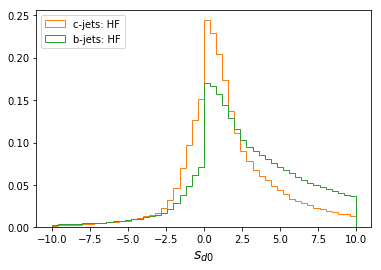

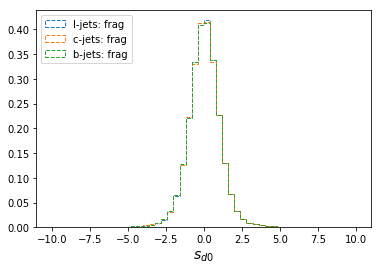

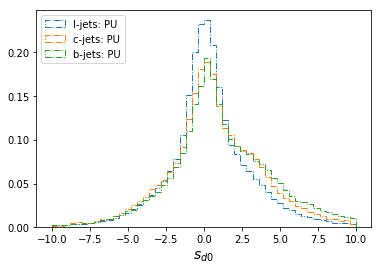

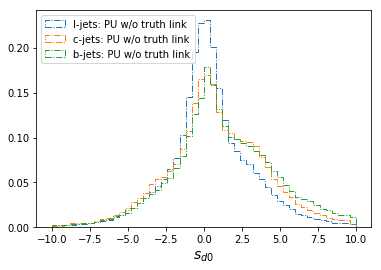

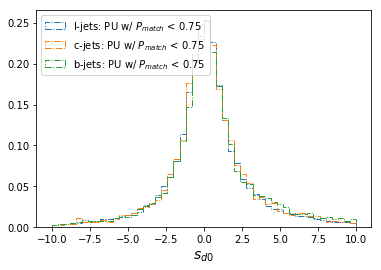

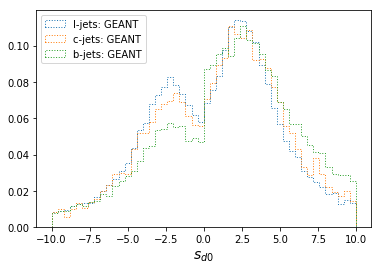

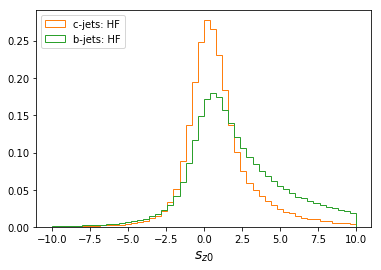

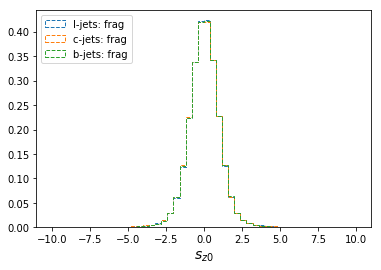

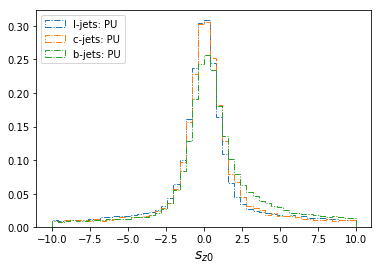

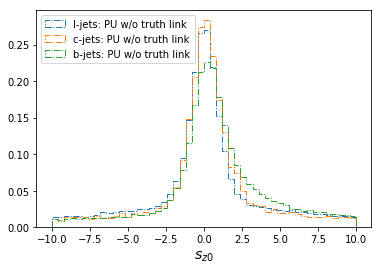

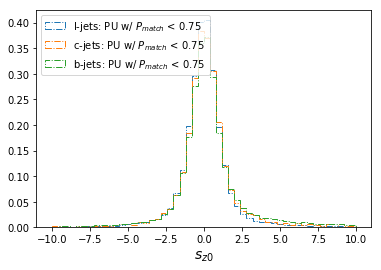

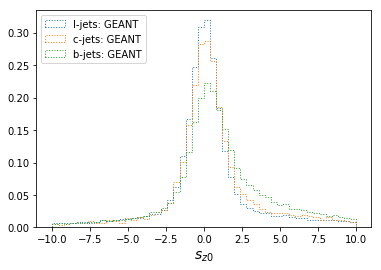

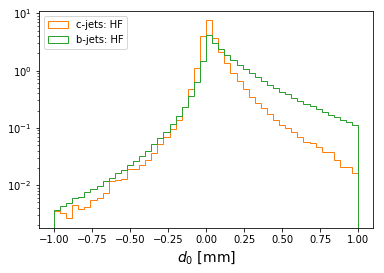

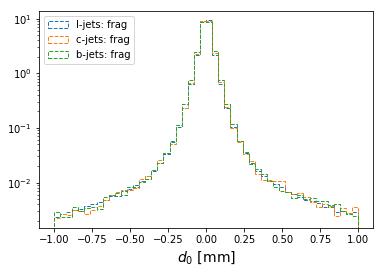

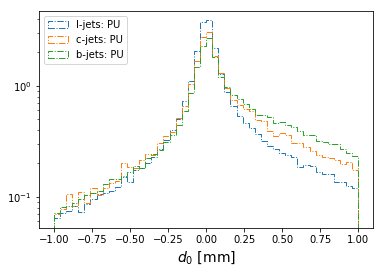

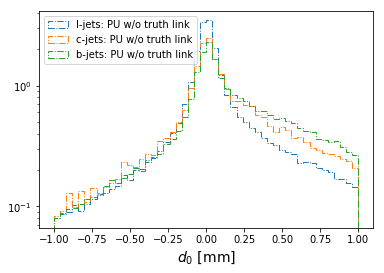

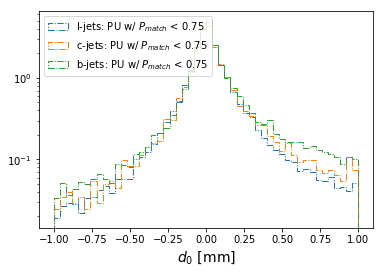

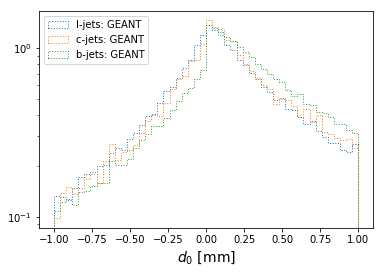

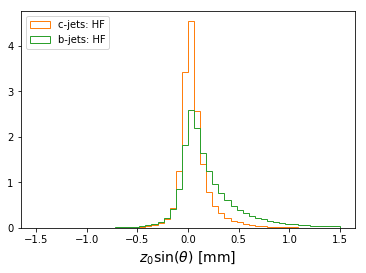

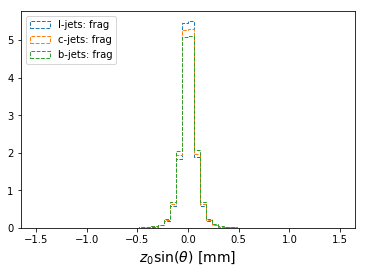

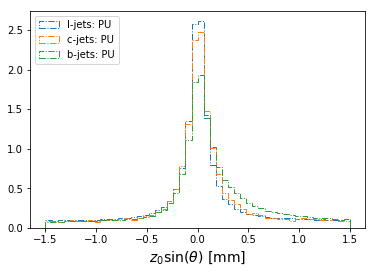

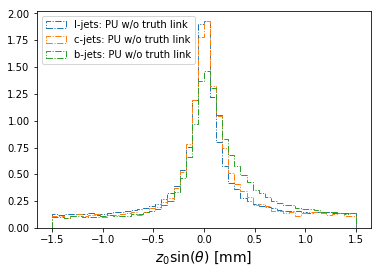

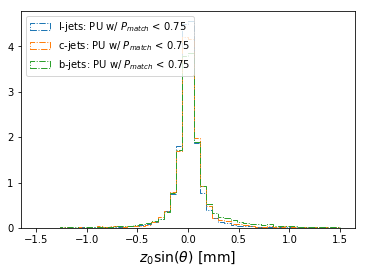

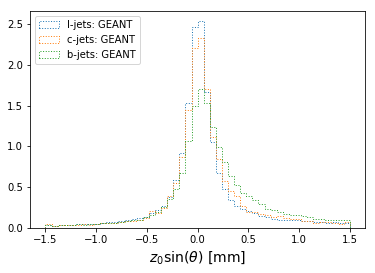

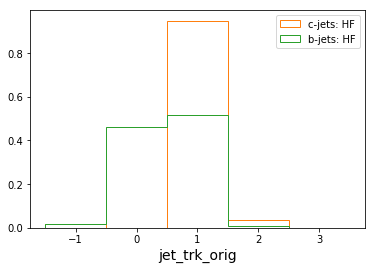

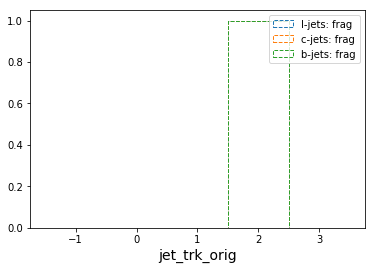

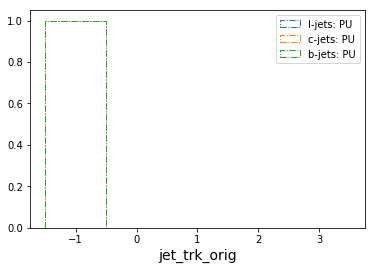

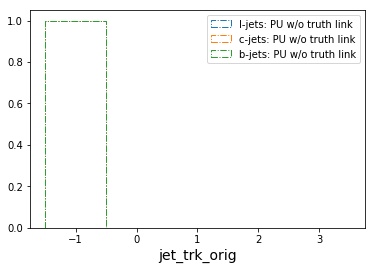

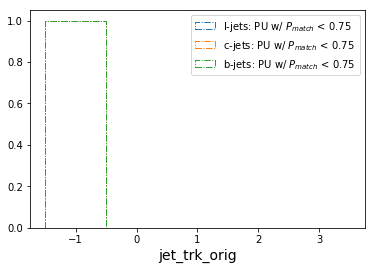

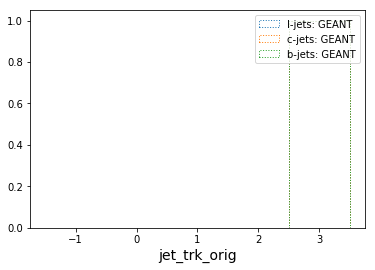

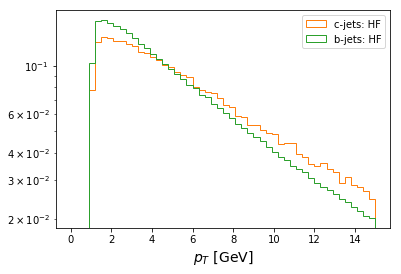

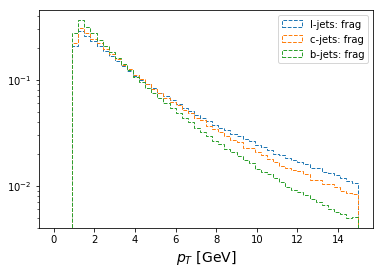

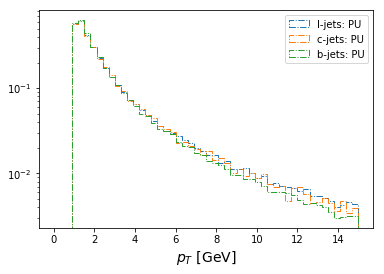

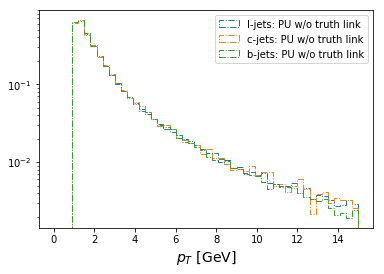

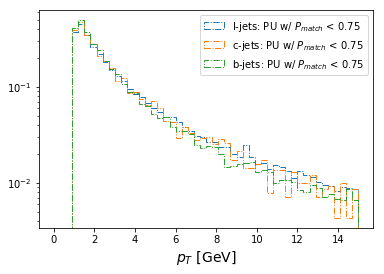

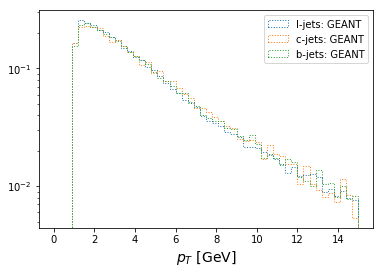

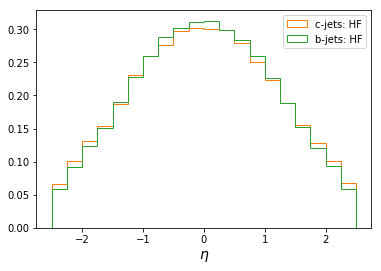

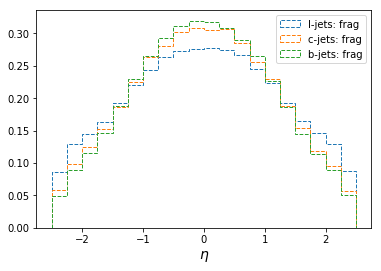

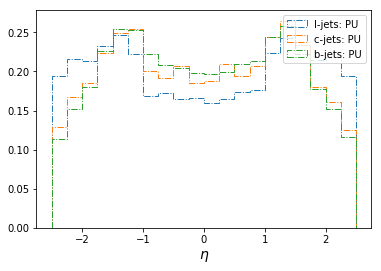

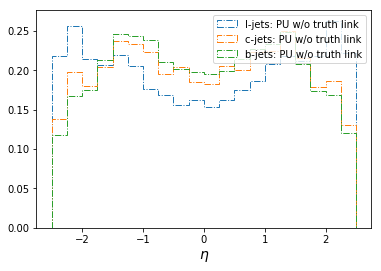

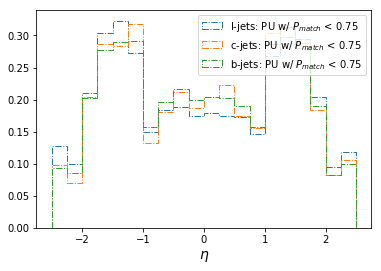

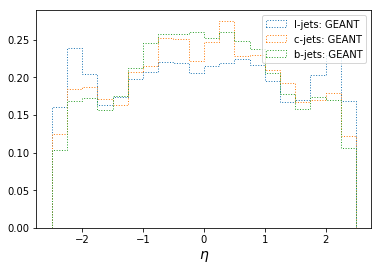

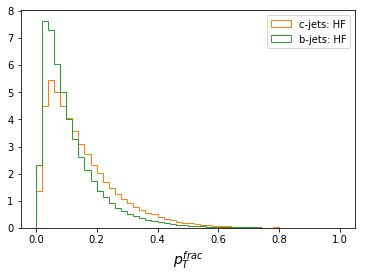

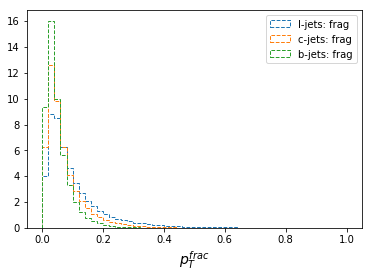

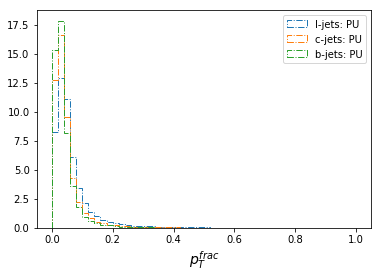

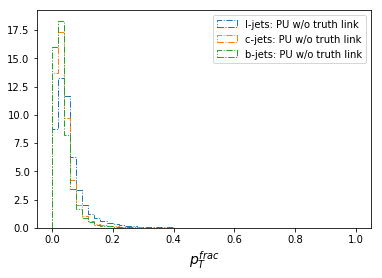

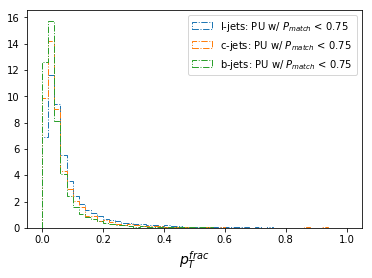

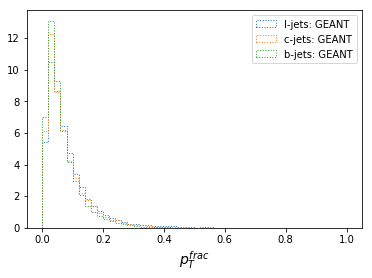

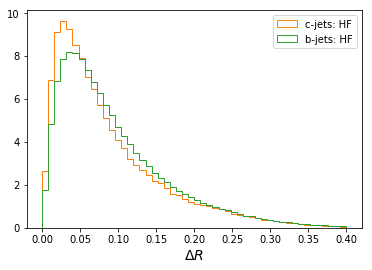

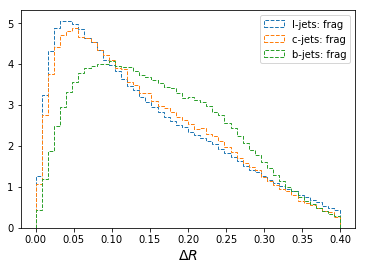

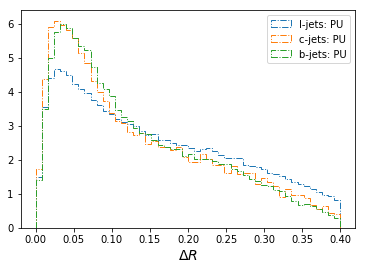

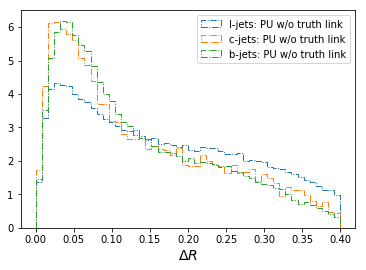

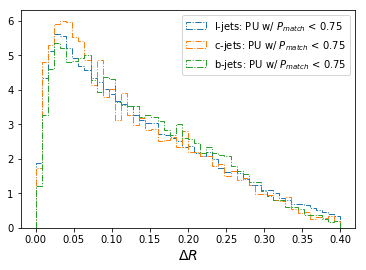

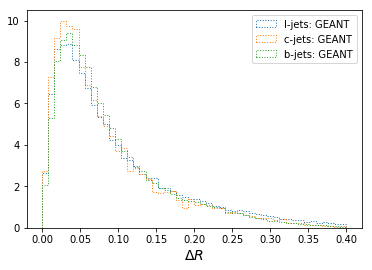

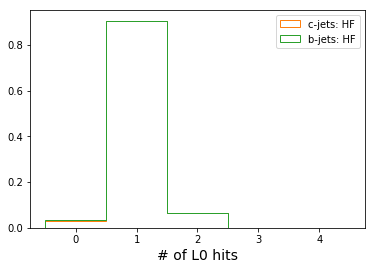

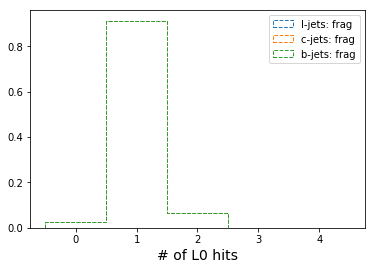

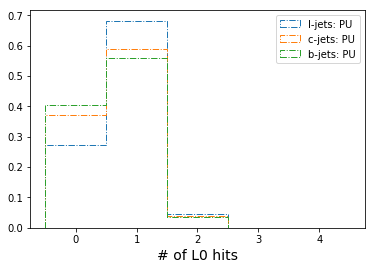

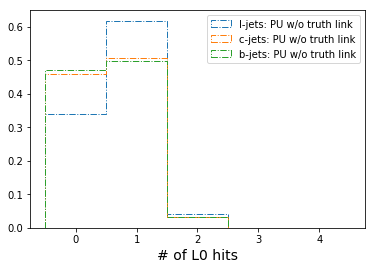

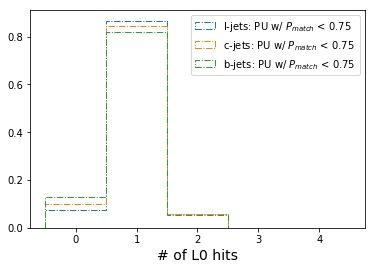

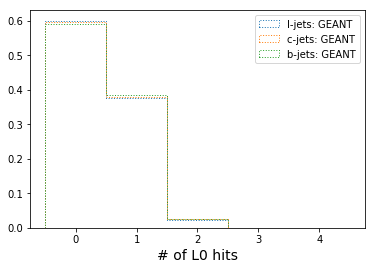

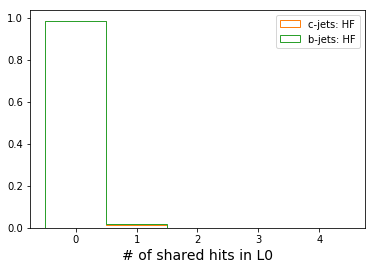

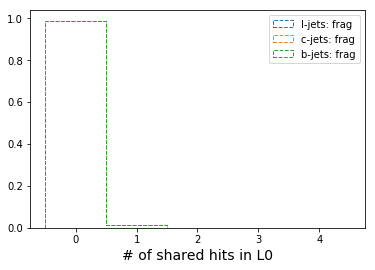

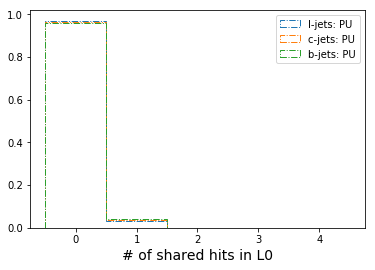

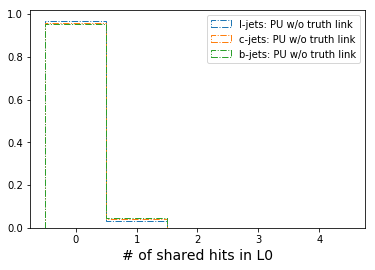

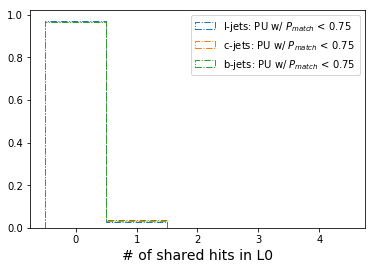

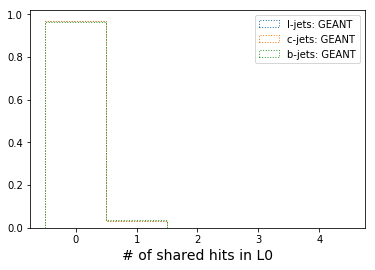

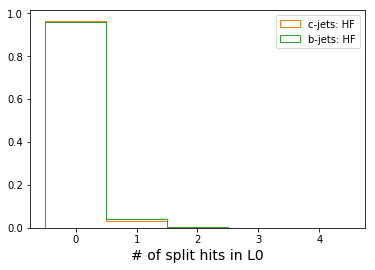

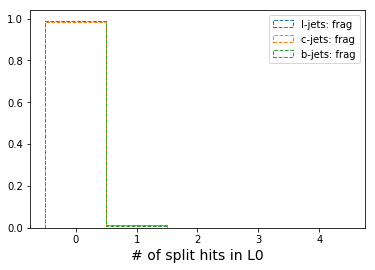

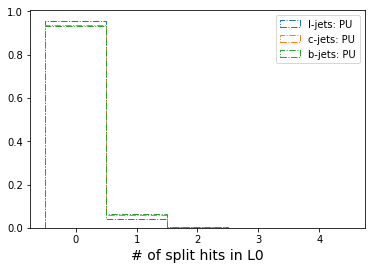

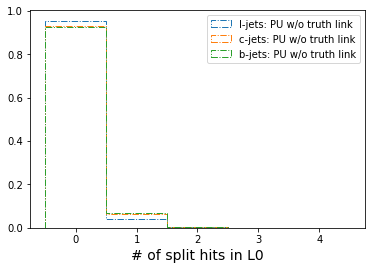

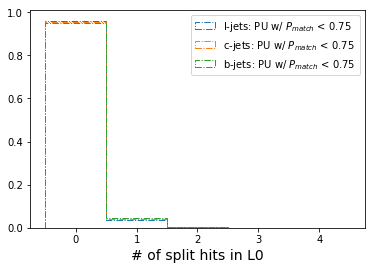

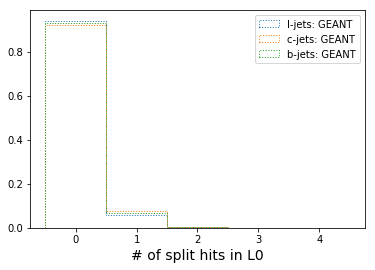

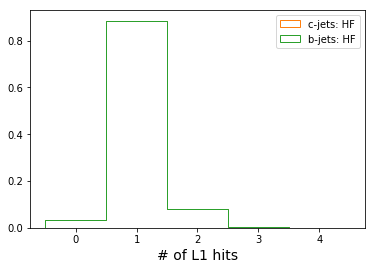

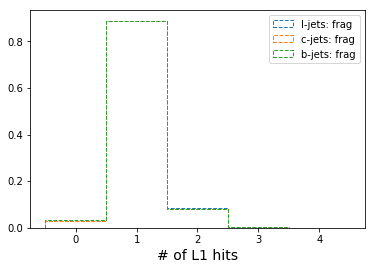

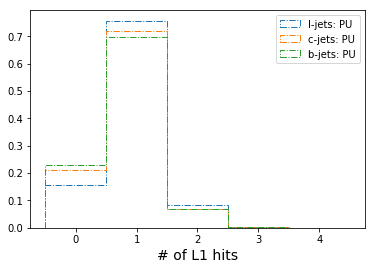

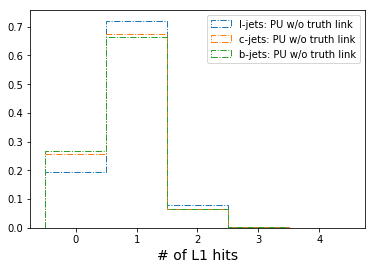

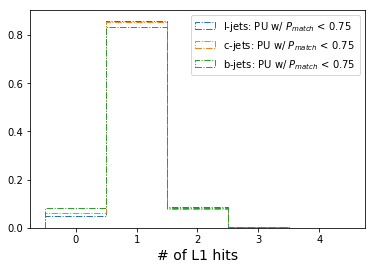

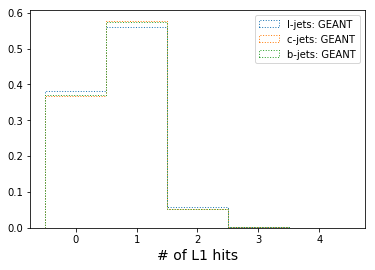

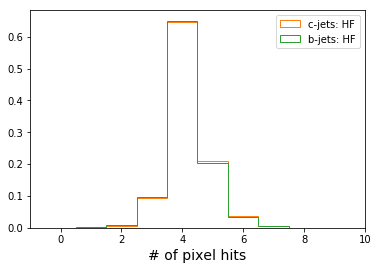

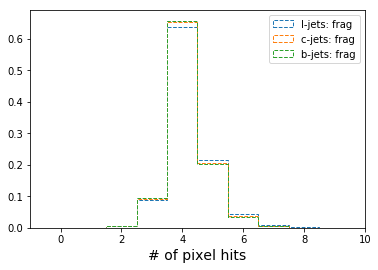

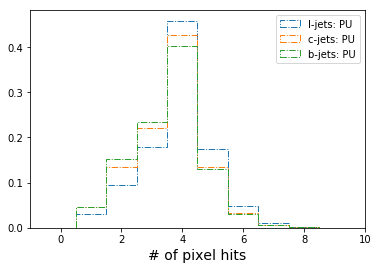

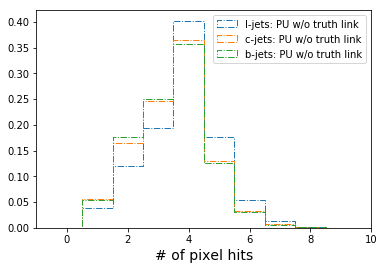

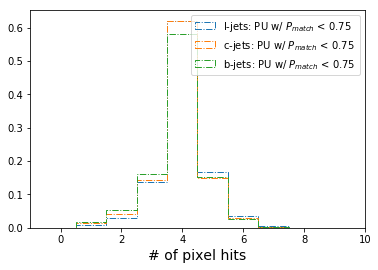

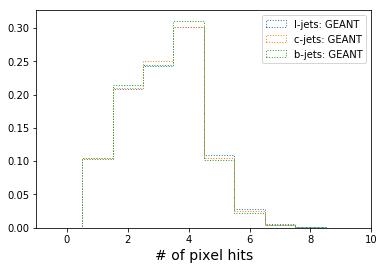

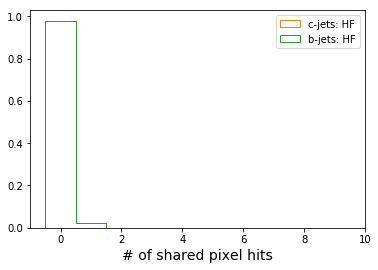

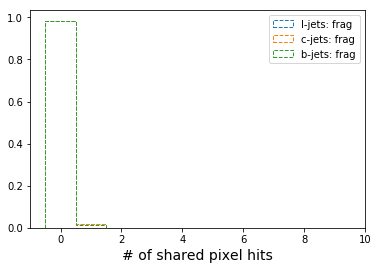

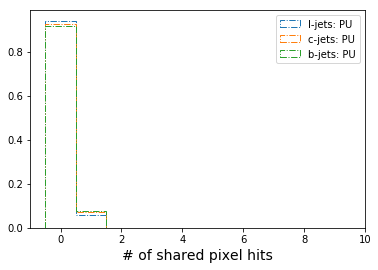

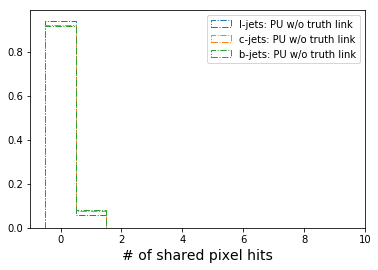

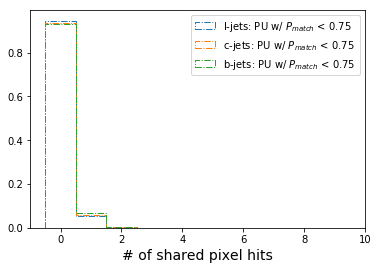

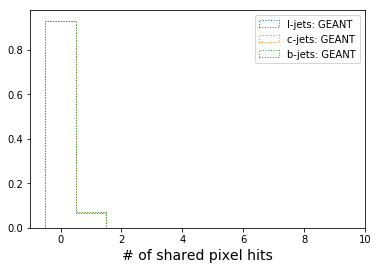

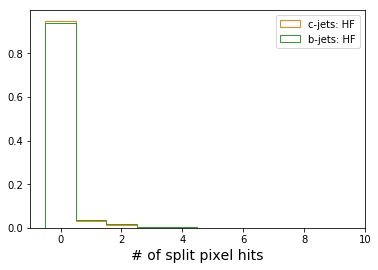

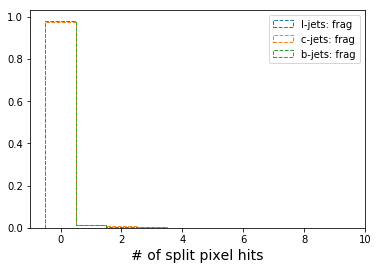

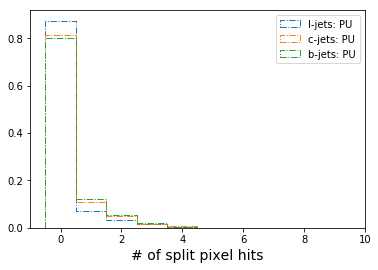

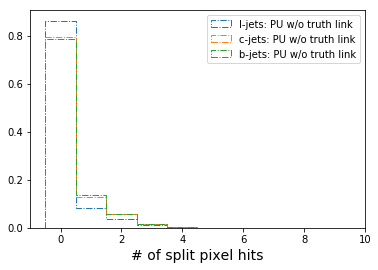

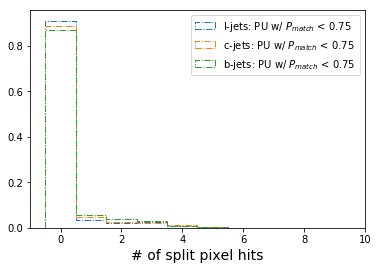

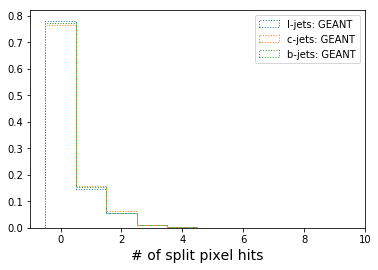

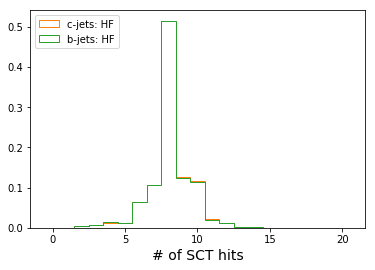

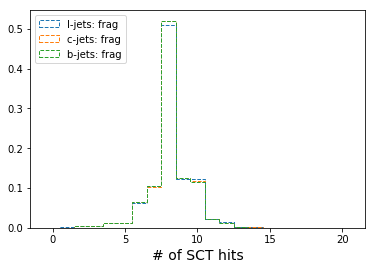

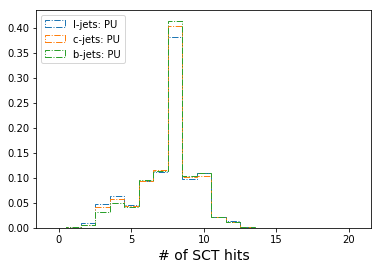

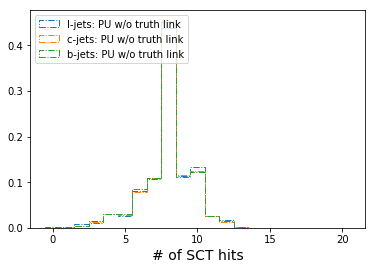

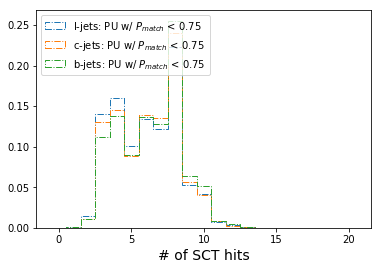

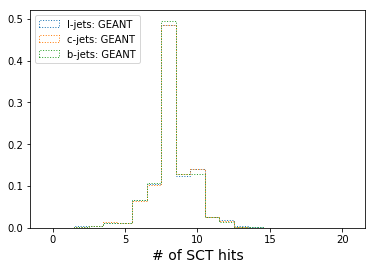

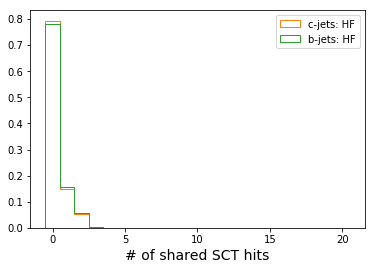

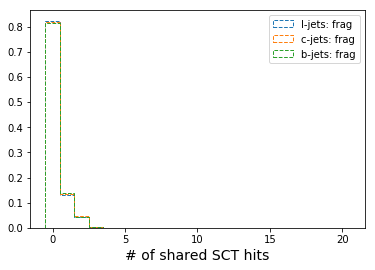

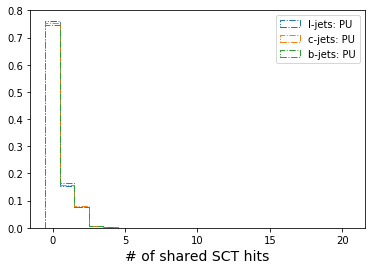

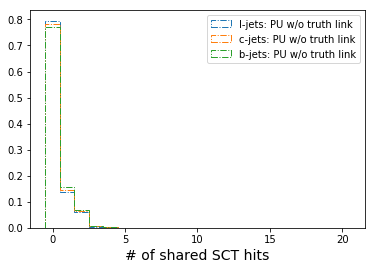

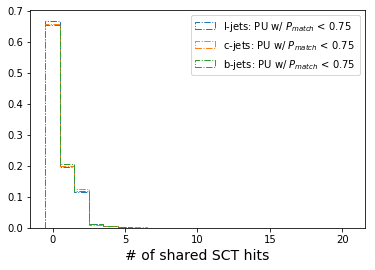

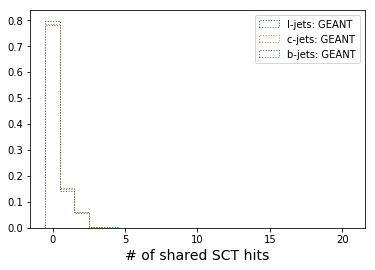

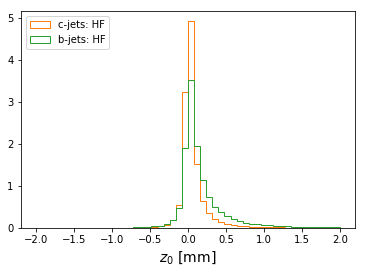

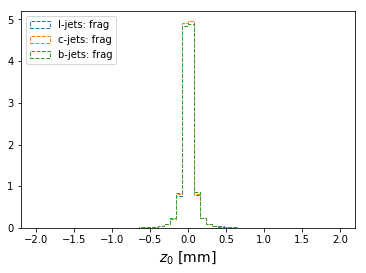

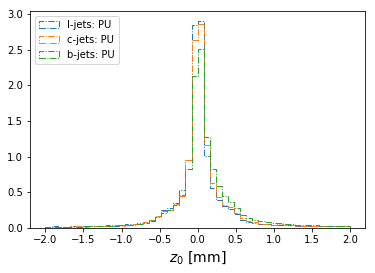

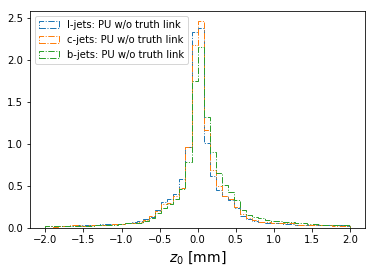

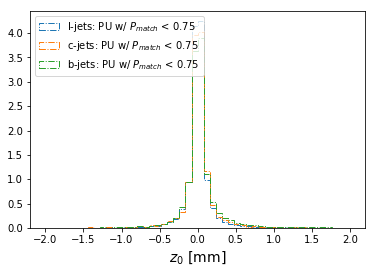

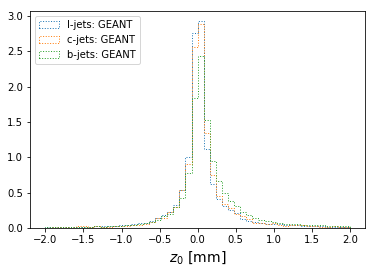

In [24]:
# Get the mask since all of the truth labels are track level variables
y_trks = np.ones_like(X[:,:,0])
y_trks = y_trks * y.reshape(-1,1)

o_trks = np.ones_like(X[:,:,0])
o_trks = o_trks * trk_labels

mask = getTrkMask(X)

# This mask selects the non-masked tracks in the jet
y_trks = y_trks[mask]
o_trks = o_trks[mask]
  
for v, xlabel, nBins, myRange, loc in zip(xr_vars,xlabels,var_bins,var_ranges, legend_loc):

    # Access the non-masked trks in the jet for this trk feature
    if v == 'z0_raw':
        var = z0_raw[mask]
    else:
        var = trk_xr.loc[:,:,v].values[mask]
    
    for oi, orig_label, orig_tag, l in zip([0,2,(-1,1),-1,1,3],
                                           ['HF','frag','PU','PU w/o truth link','PU w/ $P_{match}$ < 0.75','GEANT'],
                                           ['HF','frag','PU','PU_noTruth','PU_truthLink','GEANT'],
                                           ['-', '--', '-.', '-.', '-.', ':']):

        # Get the mask for the track origin
        if type(oi) == tuple:
            orig_mask = np.zeros_like(y_trks).astype(bool)
            for oix in oi:
                orig_mask = orig_mask | (o_trks==oix)
        else:
            orig_mask = (o_trks==oi)
                
        plt.figure()

        for yi, flav in zip(range(3), ['l','c','b']):

            if yi == 0 and oi == 0:
                continue
                
            plt.hist(var[orig_mask & (y_trks == yi)],
                     range=myRange,bins=nBins,
                     histtype='step', density=True, 
                     color='C{}'.format(yi), linestyle=l,
                     label='{}-jets: {}'.format(flav,orig_label))

        plt.legend(loc=loc,fontsize=10)  
        plt.xlabel(xlabel,fontsize=14)            
        plt.savefig('../../figures/newTrkLabel/{}_{}.pdf'.format(v,orig_tag))
        
        # Also save d0 w/ the log scale
        if v == 'ip3d_d0' or v == 'pt':
            plt.yscale('log', nonposy='clip')
            plt.savefig('../../figures/newTrkLabel/{}_{}_log.pdf'.format(v,orig_tag))

        plt.show()
        

## Follow-up from Chris

Chris was interested in seeing what these distributions looked like for l-jets above some $D_b$ threshold, and since I think I like the labelling better in this notebook, I'm going to go ahead and put these studies here.

**Step 1:** Load in the model


In [25]:
modelDir = '../../models/'+subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTag = "3mtrain_15trks_{}_sd0_rev".format(vStr)

inpts = vStr.split("_")
inpts.remove('logNorm')
inpts.remove('norm')

m = myLSTM(modelDir=modelDir, nFeatures=len(inpts), dataTag=dataTag, loadModel=True)

Initialize method from myModel()
Loading previously trained LSTM


In [26]:
m.modelDir

'../../models/mc16d_Topo_ttbar'

In [27]:
m.modelName

'LSTM_50units_10dense_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev'

**Step 2:** Get the discriminant

I want to make this plot w/ the "new and improved" track labels... so use the X from the trk_xr w/ the new and improved labelling!

In [28]:
inpts[-4:-2]

['ptfrac', 'dr']

In [29]:
mask = ~ np.all(trk_xr.values == 0, axis=-1)

X = trk_xr.loc[:,:,inpts].values
ix = trk_xr.indexes['jet']

print(X.shape)


# Take the log of ptfrac and dr
for j in [-4,-3]:
    X[:,:,j][mask] = np.log(X[:,:,j][mask])

# Open the scaling file
scalingfile = "../../data/mc16d_Topo_ttbar/scale_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json"

# Normalize
scale(X[:,:,-4:], inpts[-4:], savevars=False, filename=scalingfile)


(850001, 15, 13)
Scaling feature 1 of 4 (ptfrac).
Scaling feature 2 of 4 (dr).
Scaling feature 3 of 4 (nPixHits).
Scaling feature 4 of 4 (nSCTHits).


In [30]:
pdg_to_class = {0:0, 4:1, 5:2, 15:3}
y = jet_df.LabDr_HadF.replace(pdg_to_class).values

min: -5.84, max: 11.35


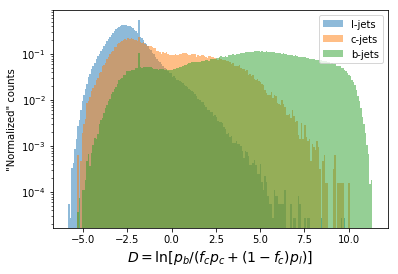

In [31]:
eff_file = "{}/effs_{}.json".format(m.modelDir,m.modelName)

if os.path.exists(eff_file):
    
    print('Could just load in the eff file')
    
(leff,ceff,beff),disc = getEffs(m, X, y, ix,returnDisc=True,
                                figDir='../../figures/',subDir=subDir,
                                modelDir=m.modelDir)

Sanity check: How does the roc curve look?

../../plottingFcts.py:525: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


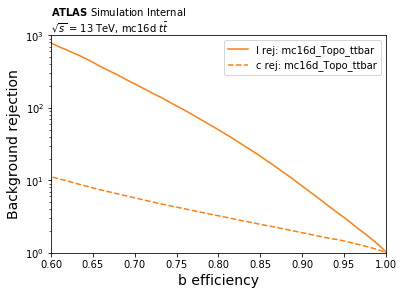

In [32]:
btagROC([beff],[leff],[ceff],[subDir],colors=['C1'])

**Step 3:** Find the disc cut for the 70% WP

In [33]:
cut_70 = workingPoint(disc[y==2], nBins=100, myRange=(-14,14))

i_eff = 41, teff = 0.7066301374059072
Cut on discriminant at 2.240000009536743


**First look at the leading $s_{d0}$ track.**

In [34]:
trk_labels.shape

(850001, 15)

In [35]:
label_trk0 = trk_labels[:,0]

In [36]:
mask[:,0].sum()

837324

I think it makes sense *not* to normalize the distributions for the first track in the jet, becuase it's useful to know *which* type of track is leading to such a large IP.

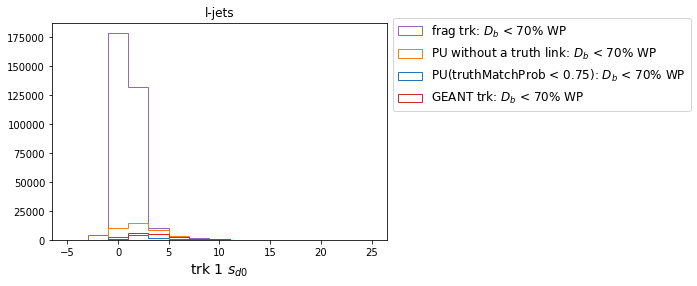

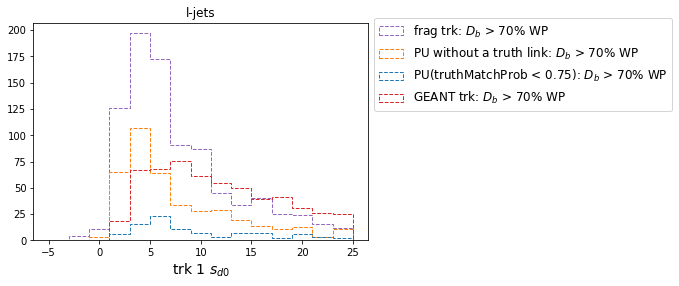

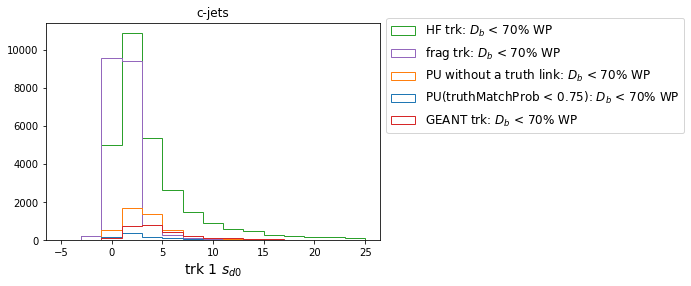

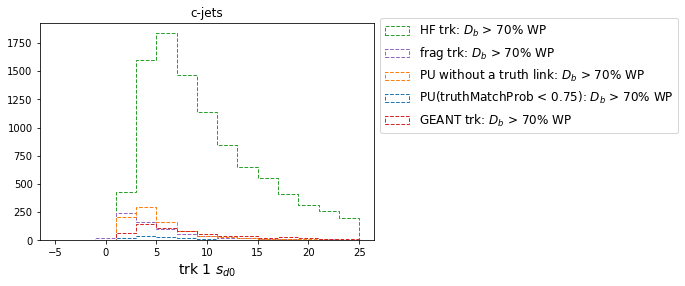

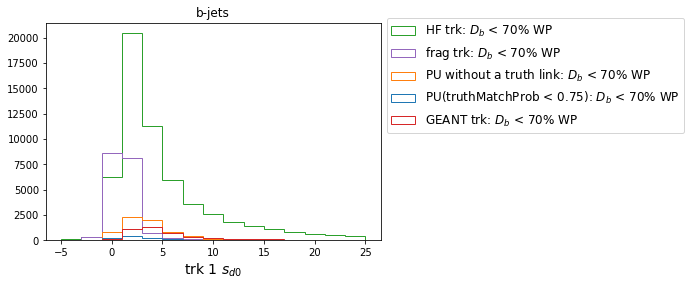

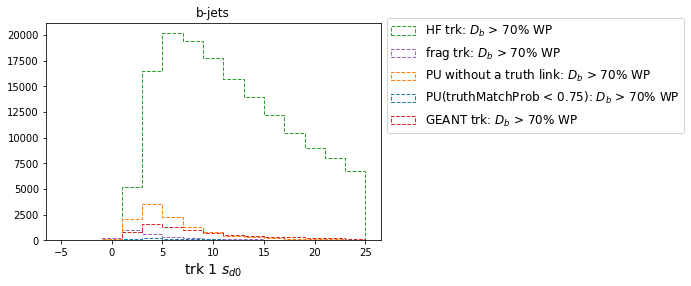

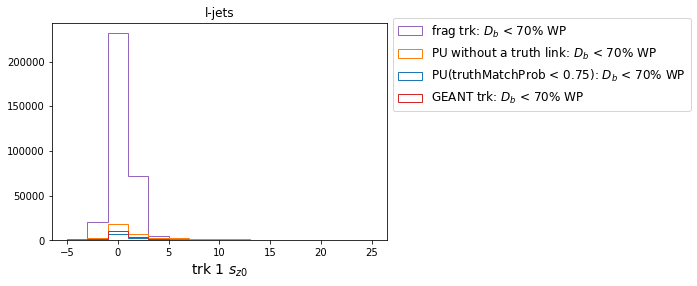

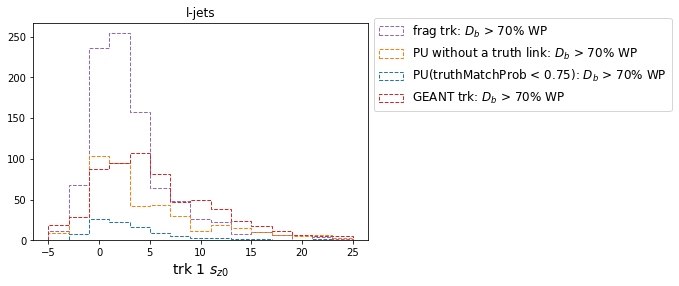

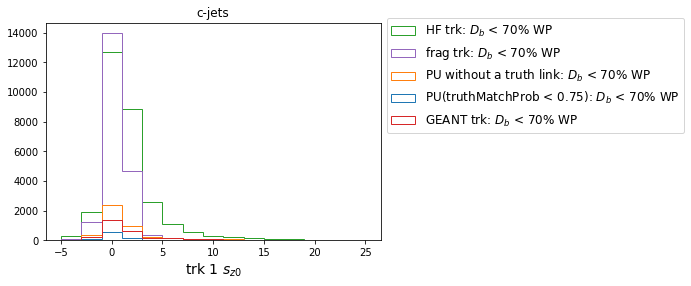

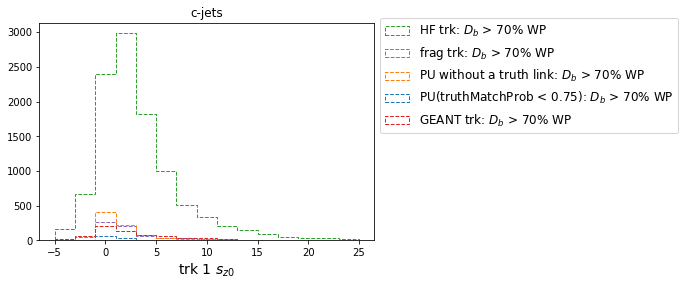

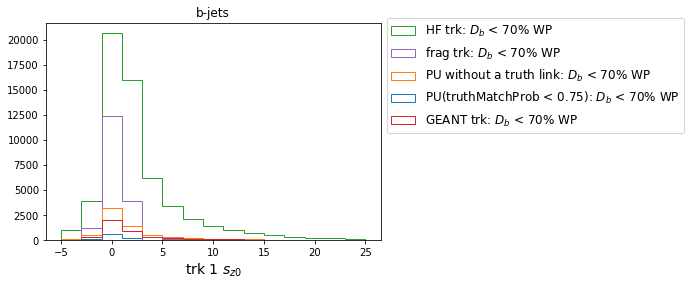

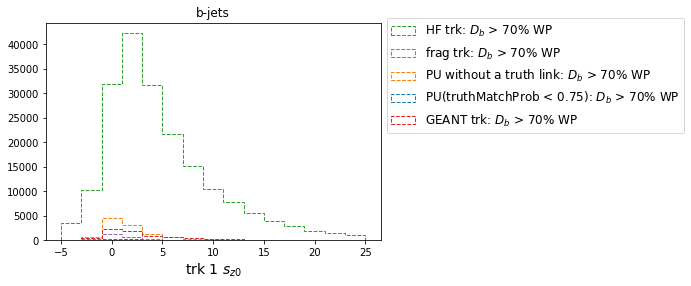

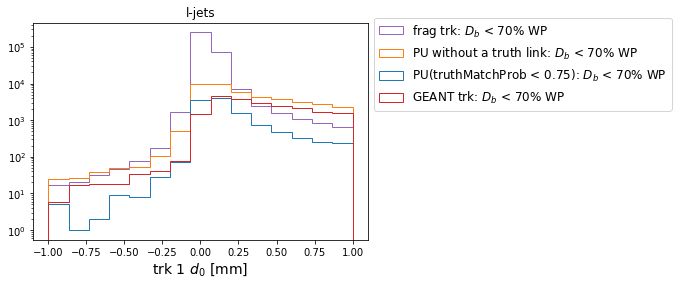

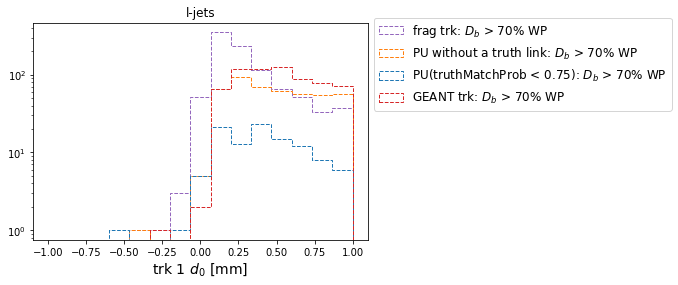

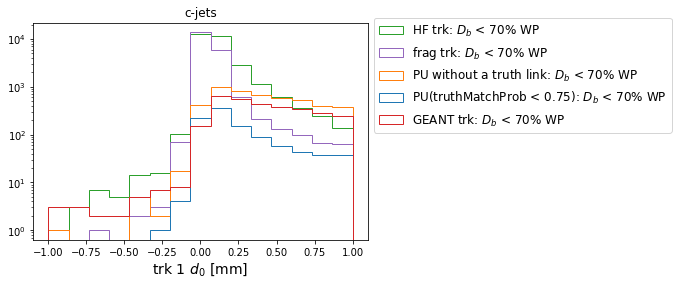

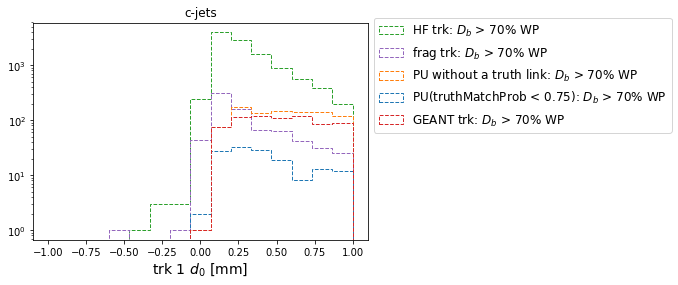

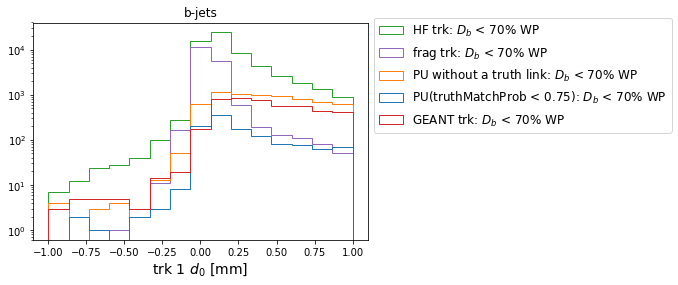

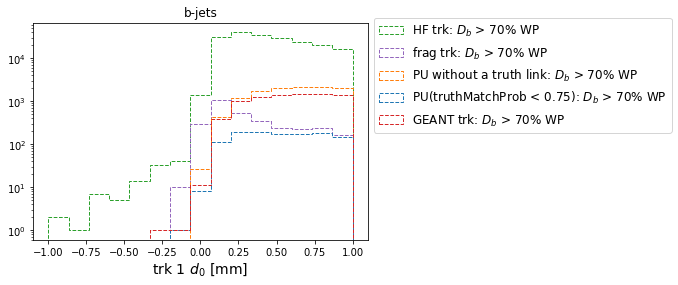

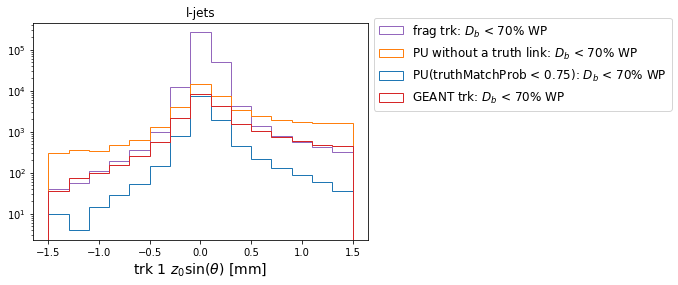

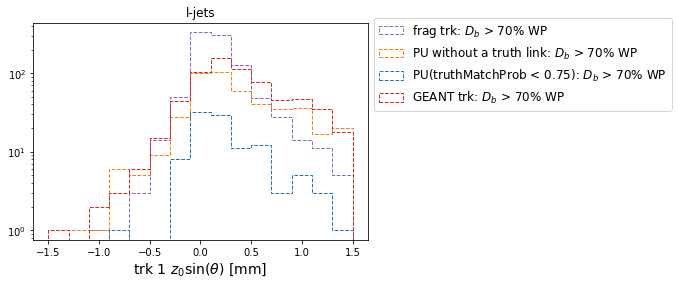

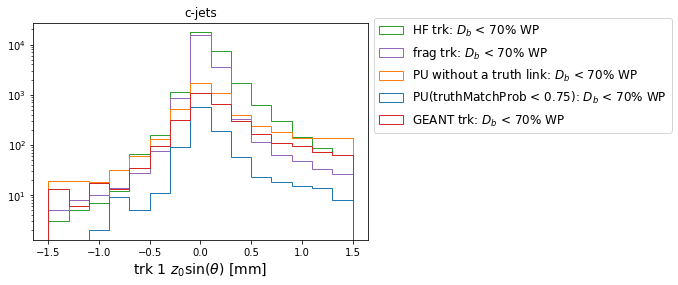

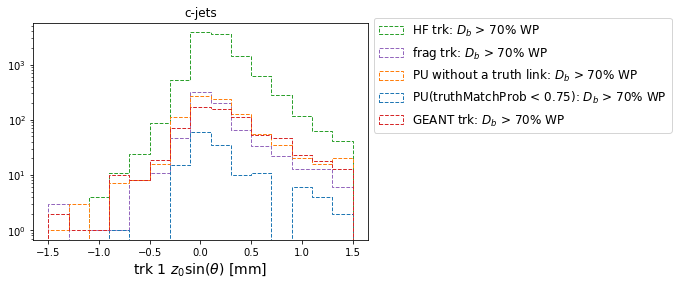

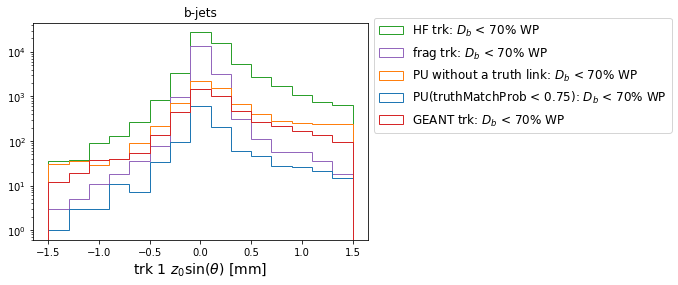

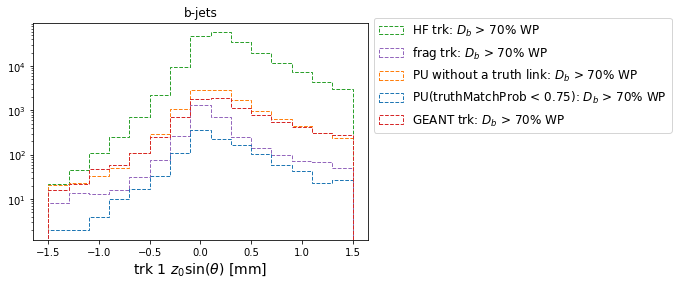

In [40]:
for v, xlabel, nBins, myRange in zip(xr_vars[:4],xlabels[:4],[15,15,15,15],[(-5,25)]*2+[(-1,1),(-1.5,1.5)]):

    # Just look at the leading sd0 trk in the jet
    var = trk_xr.loc[:,0,v].values
    
    for yi, flav in zip(range(3), ['l','c','b']):
    
        for sgn, l in zip(['<','>'],['-','--']):
    
            plt.figure()
    
            if sgn == '<':
                sgn_mask = (disc < cut_70)
            else:
                sgn_mask = (disc > cut_70)
            
    
            for oi, orig_label, orig_tag, c in zip([0,2,-1,1,3],
                                                   ['HF trk','frag trk','PU without a truth link','PU(truthMatchProb < 0.75)','GEANT trk'],
                                                   ['HF','frag','PU_noTruth','PU_truthLink','GEANT'],
                                                   ['C2','C4','C1','C0','C3']):
                       
                # Don't put HF tracks in l-jets in the legend
                if (yi == 0) and (oi == 0):
                    continue
                
                # Note: The last mask just ensures that we're not including trackless
                # jets in this plot
                plt.hist(var[(y == yi) & sgn_mask & (label_trk0 == oi) & mask[:,0]],
                         range=myRange,bins=nBins,
                         histtype='step', #density=True, 
                         color=c, linestyle=l,
                         label='{}: $D_b$ {} 70% WP'.format(orig_label,sgn))

            plt.legend(fontsize=12,bbox_to_anchor=(1,1.05))  
            plt.xlabel('trk 1 ' + xlabel,fontsize=14)      
            plt.title('{}-jets'.format(flav))
            plt.savefig('../../figures/newTrkLabel/{}jets_{}{}70%WP_trk1_noNorm.pdf'.format(flav,v,sgn),
                        bbox_inches='tight')

            # Also save d0 w/ the log scale
            if 'ip3d' in v:
                plt.yscale('log', nonposy='clip')
                plt.savefig('../../figures/newTrkLabel/{}jets_{}{}70%WP_trk1_noNorm_log.pdf'.format(flav,v,sgn),
                            bbox_inches='tight')

            plt.show()

**Thoughts**
- It's almost always the GEANT track that is confusing the light jets
- Rhe PU tracks that are the second most detrimental category

**Now look at all of the tracks in the jet.**

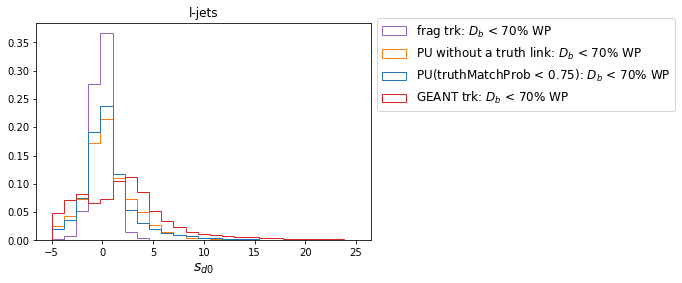

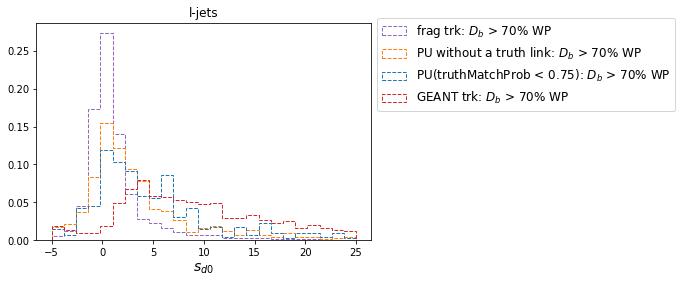

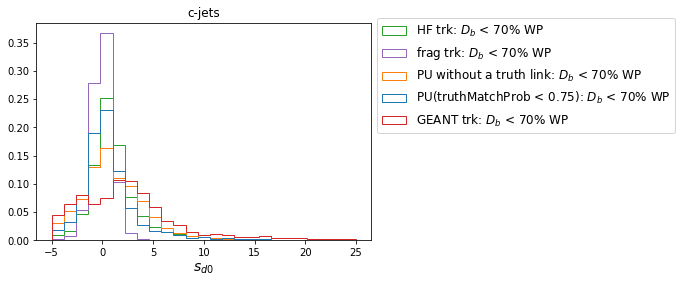

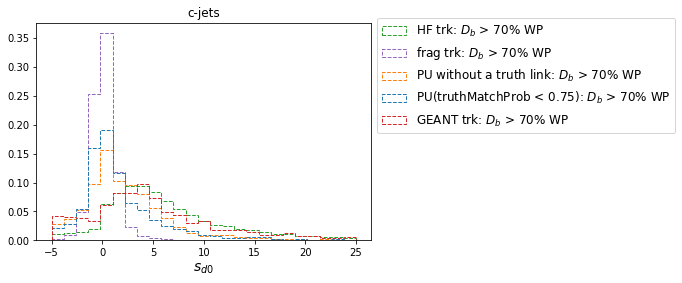

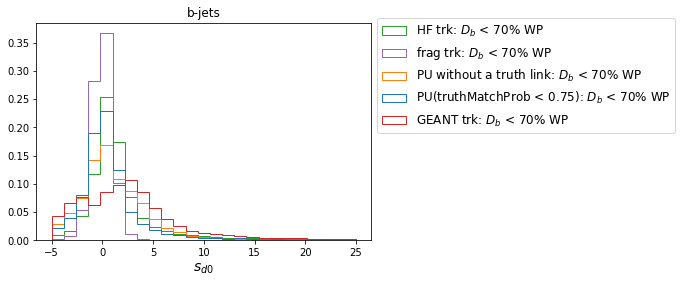

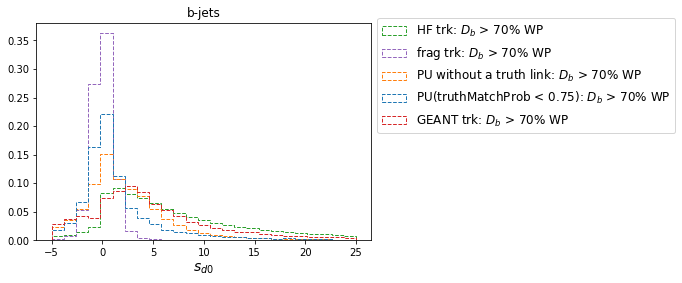

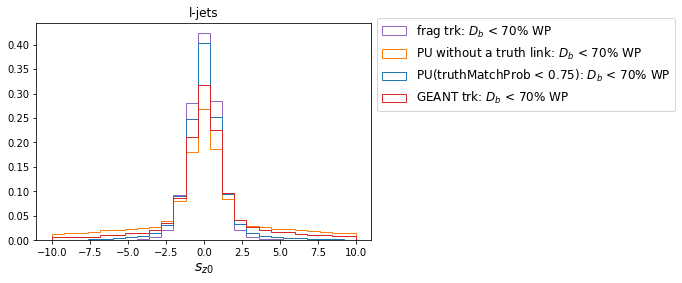

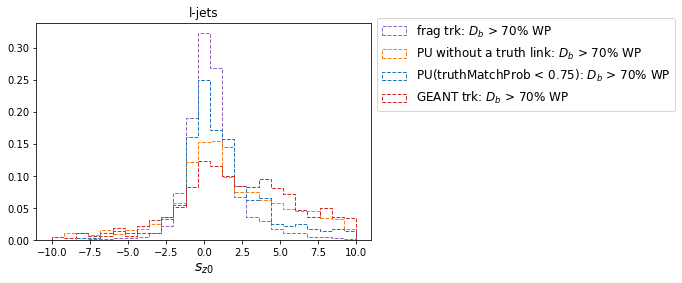

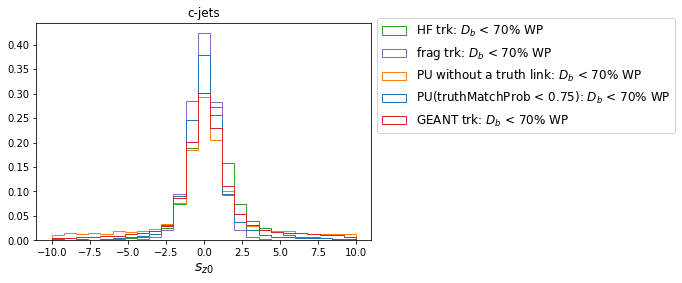

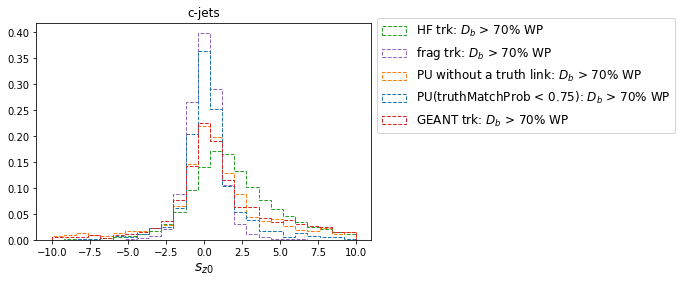

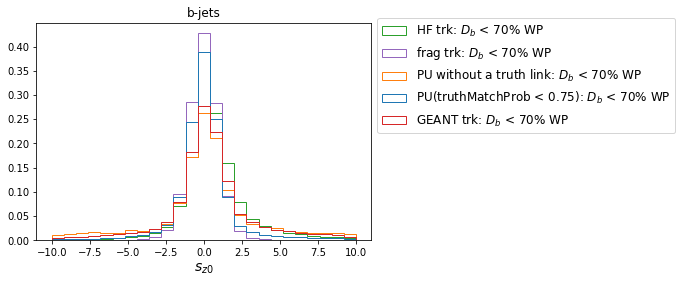

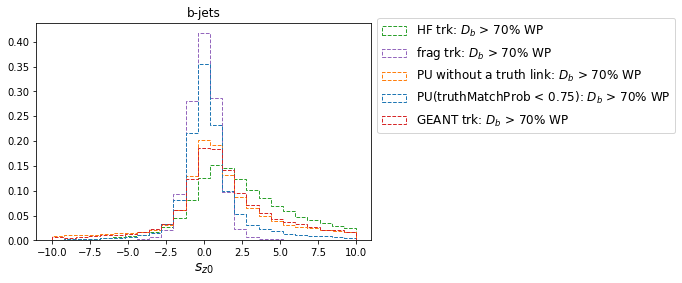

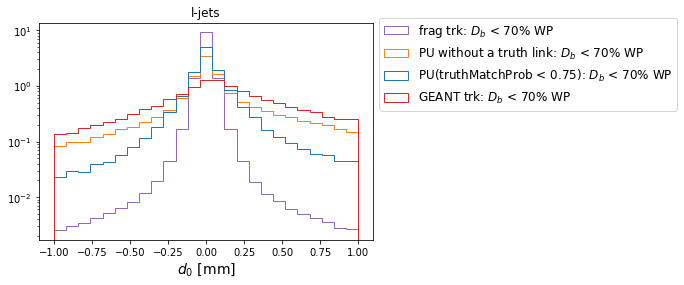

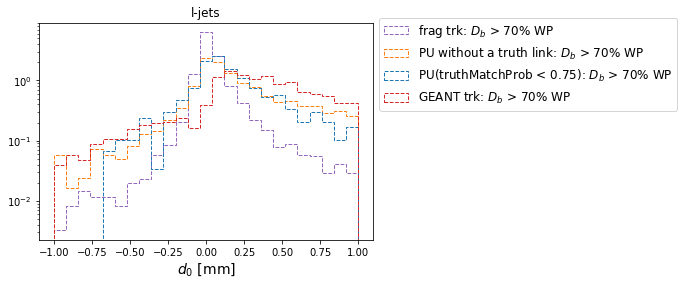

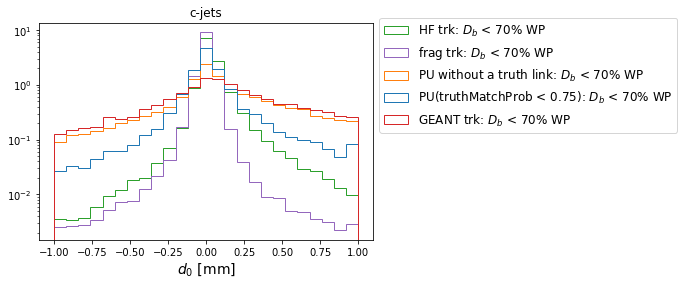

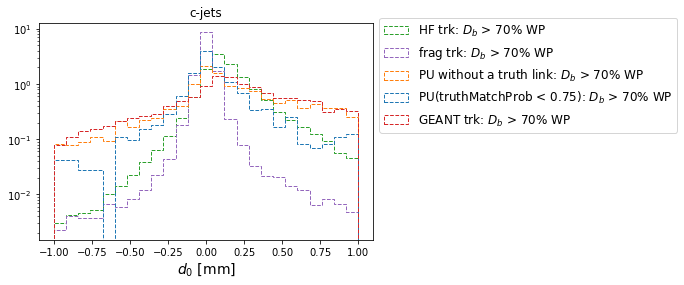

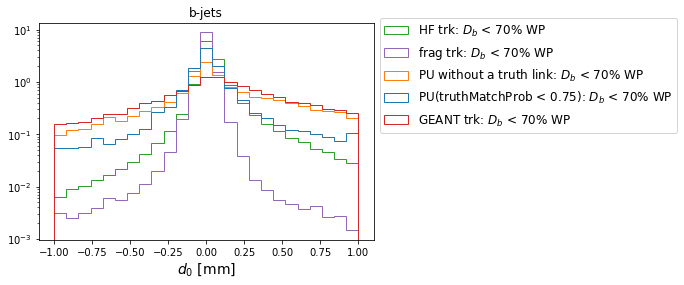

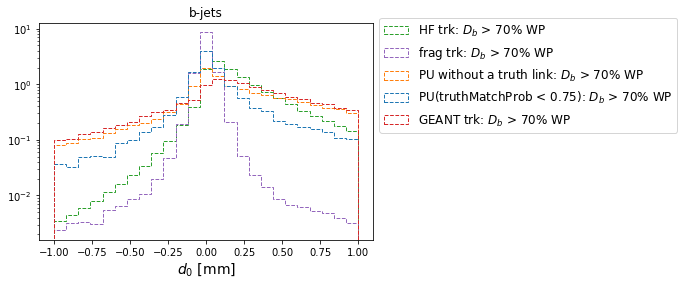

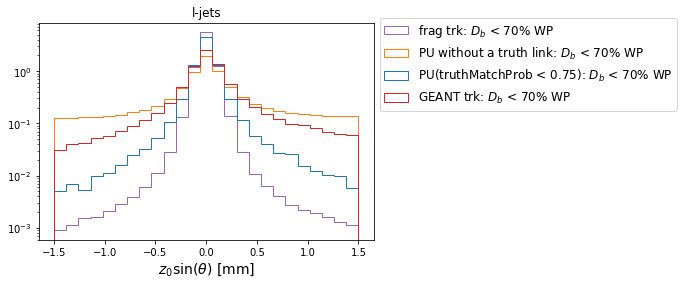

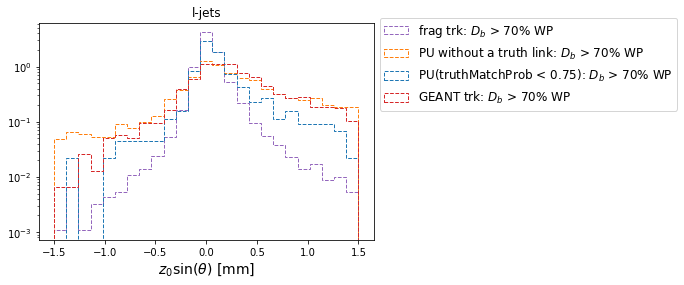

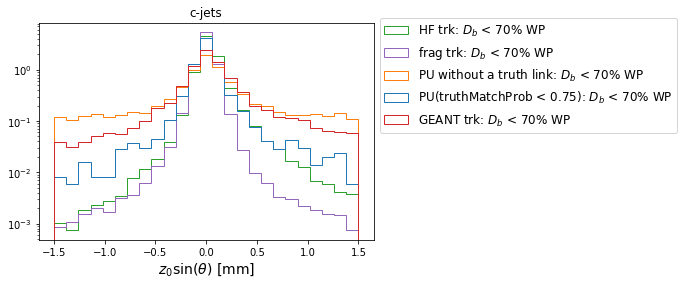

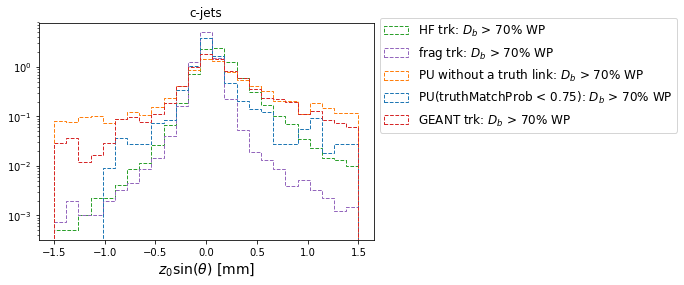

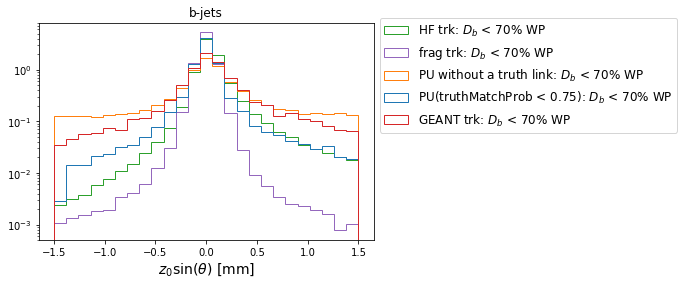

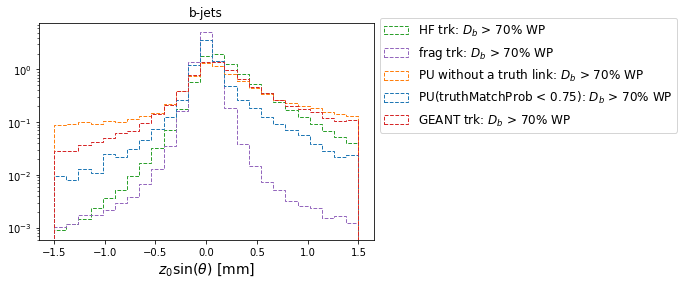

In [41]:
disc_trks = np.ones_like(X[:,:,0])
disc_trks = disc_trks * disc.reshape(-1,1)
disc_trks = disc_trks[mask]

for v, xlabel, nBins, myRange in zip(xr_vars[:4],xlabels[:4],[25,25,25,25,25],[(-5,25)]+var_ranges[1:4]):

    # Just look at the leading sd0 trk in the jet
    var = trk_xr.loc[:,:,v].values[mask]
    
    for yi, flav in zip(range(3), ['l','c','b']):
    
        for sgn, l in zip(['<','>'],['-','--']):
    
            plt.figure()
    
            if sgn == '<':
                sgn_mask = (disc_trks < cut_70)
            else:
                sgn_mask = (disc_trks > cut_70)
            
    
            for oi, orig_label, orig_tag, c in zip([0,2,-1,1,3],
                                                   ['HF trk','frag trk','PU without a truth link','PU(truthMatchProb < 0.75)','GEANT trk'],
                                                   ['HF','frag','PU_noTruth','PU_truthLink','GEANT'],
                                                   ['C2','C4','C1','C0','C3']):
                       
                # Don't put HF tracks in l-jets in the legend
                if (yi == 0) and (oi == 0):
                    continue
                
                # Note: The last mask just ensures that we're not including trackless
                # jets in this plot
                plt.hist(var[(y_trks == yi) & sgn_mask & (o_trks==oi)],
                         range=myRange,bins=nBins,
                         histtype='step', density=True, 
                         color=c, linestyle=l,
                         label='{}: $D_b$ {} 70% WP'.format(orig_label,sgn))

            plt.legend(fontsize=12,bbox_to_anchor=(1,1.05))  
            plt.xlabel(xlabel,fontsize=14)      
            plt.title('{}-jets'.format(flav))
            plt.savefig('../../figures/newTrkLabel/{}jets_{}{}70%WP.pdf'.format(flav,v,sgn),bbox_inches='tight')

            # Also save d0 w/ the log scale
            if 'ip3d' in v:
                plt.yscale('log', nonposy='clip')
                plt.savefig('../../figures/newTrkLabel/{}jets_{}{}70%WP_log.pdf'.format(flav,v,sgn),bbox_inches='tight')

            plt.show()